In [1]:
# prompt: input file dari luar/upload
# terima kaggle json
# download pip kaggle
# dowload dataset /CooperUnion/anime-recommendations-database
# infalte zip
# pip install lgihtfm

from google.colab import files
files.upload() # Upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip anime-recommendations-database.zip

!pip install lightfm

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 1.24GB/s]
Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829223 sha256=a9c0ba9523f6f8612193237924d356dcff755fdce5e9ac64a34d69e7c8537a69
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


# Import Module & Library

In [2]:
# Manipulasi Data
import pandas as pd
import numpy as np
import random
from collections import Counter
from itertools import combinations
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns

# Content-Based Filtering
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# Collaborative Filtering (LightFM)
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Konfigurasi Visualisasi (opsional, bisa diletakkan sebelum plotting)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('pastel')

# Data Wrangling

##Load Data

In [3]:
anime_df = pd.read_csv('/content/anime.csv')
rating_df = pd.read_csv('/content/rating.csv')

if anime_df is not None and not anime_df.empty and rating_df is not None and not rating_df.empty:
    print("Data berhasil dibaca dari file CSV.")
else:
    print("Gagal membaca data dari file CSV.")

Data berhasil dibaca dari file CSV.


## Assesing Data

## Data Anime

In [4]:
#lihat 5 data teratas anime
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
# lihat 5 data terakhir anime
anime_df.tail()

,anime_id,name,genre,type,episodes,rating,members
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12293,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


In [6]:
# info mengenai banyak data, nama kolom, tipe data
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
#bentuk dataframe
anime_df.shape

(12294, 7)

In [8]:
#deskripsi data numerikal
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [9]:
#cek data duplikat
print("Jumlah duplikat:", anime_df.duplicated().sum())

Jumlah duplikat: 0


In [10]:
#cek data yang missing value
print("Jumlah nilai kosong (NaN):")
print(anime_df.isna().sum())

Jumlah nilai kosong (NaN):
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


**Insight Dataset Anime**

Berdasarkan analisis awal pada dataset anime, ditemukan beberapa karakteristik penting:

---

**Struktur Data**

- Dataset terdiri dari **6 kolom utama**: `anime_id`, `name`, `genre`, `type`, `episodes`, `rating`, dan `members`.
- Tipe data masing-masing kolom:
  - **1 kolom** bertipe *float*: `rating`
  - **2 kolom** bertipe *integer*: `anime_id`, `members`
  - **4 kolom** bertipe *object/string*: `name`, `genre`, `type`, `episodes` (sebelum konversi)
- Terdapat **12.294 baris data**, yang mengindikasikan adanya informasi untuk sekitar **12.293 judul anime** (dengan asumsi `anime_id` bersifat unik dan satu baris mewakili satu anime).

---

**Distribusi Rating**

- Skala rating yang diberikan dalam dataset berkisar dari **rating terendah 1.67** hingga **tertinggi 10.0**.
- Ini menunjukkan adanya **keragaman kualitas** atau **penerimaan pengguna** terhadap berbagai judul anime.

---

**Kualitas Data**

- **Tidak ada data duplikat** ditemukan dalam dataset, yang menunjukkan **keunikan entri per baris**.
- Terdapat **missing values** pada beberapa kolom:
  - `genre`: **62 baris** tidak memiliki informasi genre.
  - `type`: **25 baris** tidak memiliki informasi tipe penayangan (misalnya TV, Movie, OVA).
  - `rating`: **230 baris** tidak memiliki nilai rating.

**Interpretasi Missing Values**
- Beberapa judul anime mungkin:
  - Belum mendapatkan rating dari pengguna atau ratingnya belum tercatat.
  - Belum memiliki informasi lengkap mengenai **format penayangan** dan **genre**.

---



## Data Ratings


In [11]:
#5 data teratas rating
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [12]:
#5 data terbawah rating
rating_df.tail()

,user_id,anime_id,rating
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9
7813736,73516,8074,9


In [13]:
# info mengenai banyak data, nama kolom, tipe data
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [14]:
# panjang dan lebar dataframe
rating_df.shape

(7813737, 3)

In [15]:
#deskripsi numerik data
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [16]:
#cek duplikat
print("Jumlah duplikat:", rating_df.duplicated().sum())

Jumlah duplikat: 1


In [17]:
#melihat data yang duplikat
print(rating_df[rating_df.duplicated(keep=False)])

         user_id  anime_id  rating
4499258    42653     16498       8
4499316    42653     16498       8


In [18]:
#cek data null
print("Jumlah nilai kosong (NaN):")
print(rating_df.isna().sum())

Jumlah nilai kosong (NaN):
user_id     0
anime_id    0
rating      0
dtype: int64


**Insight Dataset Rating Pengguna**

Berdasarkan analisis awal pada dataset rating pengguna, ditemukan beberapa karakteristik penting:

---

**Struktur Data**

- Dataset ini mencatat **rating yang diberikan oleh pengguna untuk setiap anime**.
- Terdiri dari **3 kolom utama**:
  - `user_id`
  - `anime_id`
  - `rating`
- Semua kolom memiliki tipe data **integer**.

---

**Skala Rating**

- Nilai rating bervariasi mulai dari **-1 hingga 10**.
- Rating **-1** kemungkinan mengindikasikan:
  - Anime yang **hanya ditambahkan ke watchlist**, tapi belum diberi skor.
  - Atau pengguna **belum selesai menonton** sehingga belum memberikan rating final.

---

**Volume Data**

- Dataset ini sangat besar, terdiri dari **7.813.737 baris data rating**.
- Hal ini mencerminkan **aktivitas dan interaksi pengguna yang tinggi** terhadap konten anime.

---

**Kualitas Data**

- Ditemukan **1 baris data duplikat**, yang perlu dihapus pada tahap **data cleaning**.
-**Tidak ada nilai kosong (NaN)** pada ketiga kolom, menunjukkan **data lengkap** dari segi keberadaan nilai.

---



### Exploratory Data Analysis

In [19]:
#melihat genre-genre
print(anime_df['genre'].unique())

['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


In [20]:
#melihat banyak genre
print(len(anime_df['genre'].unique()))

3265


In [21]:
#melihat jenis-jenis type
print(anime_df['type'].unique())

['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]


In [22]:
print("Anime dengan jumlah voters terbanyak")
anime_df.nlargest(5, 'members')

Anime dengan jumlah voters terbanyak


,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796


In [23]:
top_5_episode = anime_df.copy()
top_5_episode['episodes'] = pd.to_numeric(top_5_episode['episodes'], errors='coerce')

print("Anime dengan jumlah episode terbanyak")
top_5_episode.nlargest(5, 'episodes')

Anime dengan jumlah episode terbanyak


,anime_id,name,genre,type,episodes,rating,members
6296,12393,Oyako Club,"Comedy, Slice of Life",TV,1818.0,6.18,160
929,2471,Doraemon (1979),"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen",TV,1787.0,7.76,14233
9243,23349,Kirin Monoshiri Yakata,Kids,TV,1565.0,5.56,116
5360,6277,Manga Nippon Mukashibanashi (1976),"Fantasy, Historical",TV,1471.0,6.48,406
6580,8213,Hoka Hoka Kazoku,Comedy,TV,1428.0,6.05,194


In [24]:
print("Anime dengan rating tertinggi(berdasarkan nilai)")
anime_df.nlargest(5, 'rating')

Anime dengan rating tertinggi(berdasarkan nilai)


,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44


seperti yang terlihat bila diurutkan berdasarkan rating hasilnya kurang bagus karena jumlah voters nya terlalu sedikit

disini akan mencoba menggunakan cara yang lebih pas yakni Weighted Rating agar penilaian lebih baik

In [25]:
#mendefinisikan variable untuk perhitungan
C = anime_df['rating'].mean()
m = anime_df['members'].quantile(0.90)

In [26]:
#membuat qualified untuk menampung urutan berdasarkan perhitungan
qualified = anime_df.copy()
qualified = qualified.dropna(subset=['rating', 'members'])
qualified = qualified[qualified['members'] >= m]

In [27]:
# Hitung Weighted Rating
def weighted_rating(x, m=m, C=C):
    v = x['members']
    R = x['rating']
    return (v / (v + m)) * R + (m / (v + m)) * C

qualified['score'] = qualified.apply(weighted_rating, axis=1)

In [28]:
qualified = qualified.sort_values(by='score', ascending=False)

In [29]:
#bagi ke tiap tiap type
anime_tv = qualified[qualified['type'] == 'TV']
anime_movie = qualified[qualified['type'] == 'Movie']
anime_ova = qualified[qualified['type'] == 'OVA']

In [30]:
print("Anime TV dengan rating tertinggi(berdasarkan members)")
anime_tv.sort_values(by=['rating','members'], ascending=False).head(5)

Anime TV dengan rating tertinggi(berdasarkan members)


,anime_id,name,genre,type,episodes,rating,members,score
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.109914
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,8.463247
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.000495
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,8.542141
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,8.277114


In [31]:
print("Anime Movie dengan rating tertinggi(berdasarkan members)")
anime_movie.sort_values(by=['rating','members'], ascending=False).head(5)

Anime Movie dengan rating tertinggi(berdasarkan members)


,anime_id,name,genre,type,episodes,rating,members,score
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,8.837612
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,8.091953
11,28851,Koe no Katachi,"Drama, School, Shounen",Movie,1,9.05,102733,8.263026
15,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254,8.712991
18,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",Movie,1,8.84,226193,8.446013


In [32]:
print("Anime OVA dengan rating tertinggi(berdasarkan members)")
anime_ova.sort_values(by=['rating','members'], ascending=False).head(5)

Anime OVA dengan rating tertinggi(berdasarkan members)


,anime_id,name,genre,type,episodes,rating,members,score
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,8.163595
21,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,"Action, Drama, Historical, Martial Arts, Roman...",OVA,4,8.83,129307,8.219847
66,777,Hellsing Ultimate,"Action, Horror, Military, Seinen, Supernatural...",OVA,10,8.59,297454,8.310923
125,25781,Shingeki no Kyojin: Kuinaki Sentaku,"Action, Fantasy, Shoujo, Supernatural",OVA,2,8.45,92543,7.801658
133,2685,Tsubasa: Tokyo Revelations,"Action, Adventure, Drama, Fantasy, Romance, Sh...",OVA,3,8.44,57963,7.578692


In [33]:
#5 judul teratas versi weighted ratig
qualified.head()

,anime_id,name,genre,type,episodes,rating,members,score
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.109914
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.000495
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,8.875192
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,8.837612
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749,8.827177


tapi selanjutnya qualified tidak akan digunakan karena seperti yang terlihat urutannya berbeda dengan anime_df
sebagai catatan anime_df indexnya sudah diurutkan berdasarkan ranking oleh MAL


In [34]:
#Mencari genre yang paling sering muncul di 20 judul teratas
top_20 = anime_df.head(20).copy()

top_20['genre'] = top_20['genre'].fillna('')
top_20['genre_list'] = top_20['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

all_genres = sum(top_20['genre_list'], [])

In [35]:
genre_counts = Counter(all_genres)

In [36]:
print("Genre paling sering muncul di 20 anime teratas:")
for genre, count in genre_counts.most_common():
    print(f"{genre}: {count}")

Genre paling sering muncul di 20 anime teratas:
Shounen: 11
Drama: 10
Action: 9
Sci-Fi: 9
Comedy: 7
School: 6
Historical: 6
Parody: 5
Samurai: 5
Supernatural: 4
Adventure: 4
Fantasy: 4
Military: 4
Romance: 3
Super Power: 3
Slice of Life: 3
Sports: 2
Mecha: 2
Magic: 1
Thriller: 1
Space: 1
Music: 1
Mystery: 1
Seinen: 1


<ipython-input-37-1164f5bb8168>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df, x='Count', y='Genre', palette='pastel')


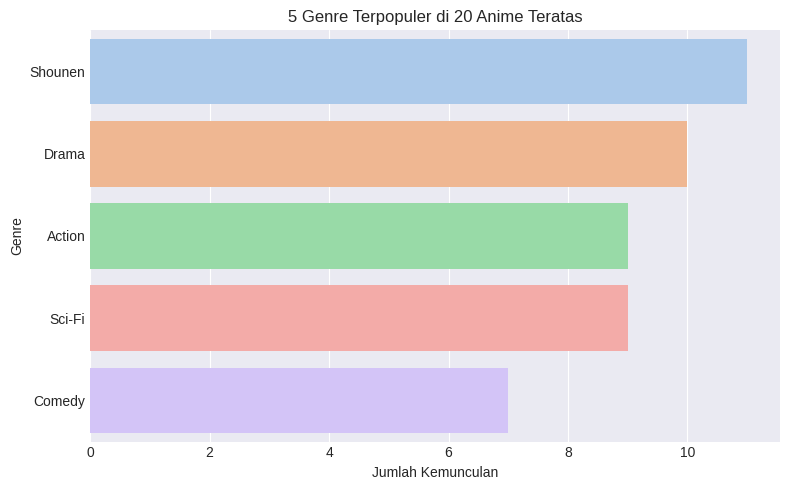

In [37]:
#visualisasi dari 5 genre terpopuler
genre_df = pd.DataFrame(genre_counts.most_common(5), columns=['Genre', 'Count'])
plt.figure(figsize=(8, 5))
sns.barplot(data=genre_df, x='Count', y='Genre', palette='pastel')
plt.title('5 Genre Terpopuler di 20 Anime Teratas')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

<ipython-input-38-23c6989122e0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=type_df, x='Count', y='Type', palette='muted')


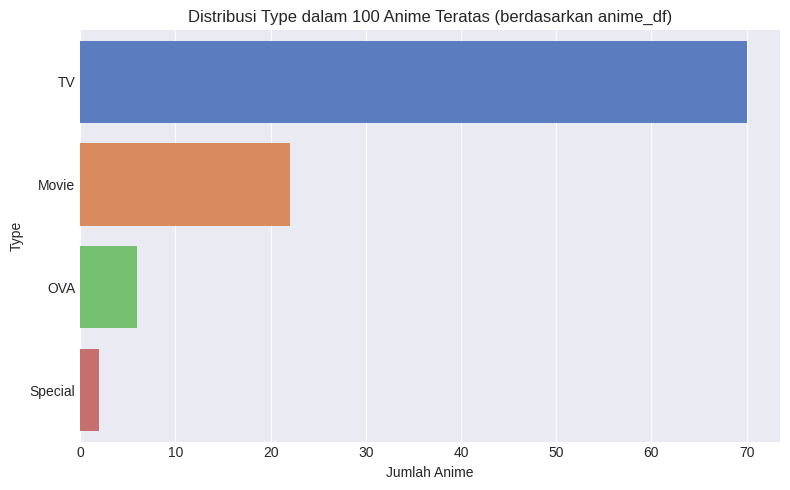

In [38]:
# Visualisasi type terbanyak

top_100 = anime_df.head(100).copy()

top_100['type'] = top_100['type'].fillna('Unknown')

type_counts = top_100['type'].value_counts()

type_df = type_counts.reset_index()
type_df.columns = ['Type', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=type_df, x='Count', y='Type', palette='muted')
plt.title('Distribusi Type dalam 100 Anime Teratas (berdasarkan anime_df)')
plt.xlabel('Jumlah Anime')
plt.ylabel('Type')
plt.tight_layout()
plt.show()


In [39]:
# visualisasi 5 pasangan genre yang paling sering muncul bersama

pair_counts = Counter()
for genre_list in top_20['genre_list']:
    if len(genre_list) >= 2:
        pairs = combinations(sorted(genre_list), 2)
        pair_counts.update(pairs)
top_pairs = pair_counts.most_common(5)

pair_df = pd.DataFrame(top_pairs, columns=['Pair', 'Count'])
pair_df['Pair'] = pair_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")



<ipython-input-40-f592aff423e9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_df, x='Count', y='Pair', palette='pastel')


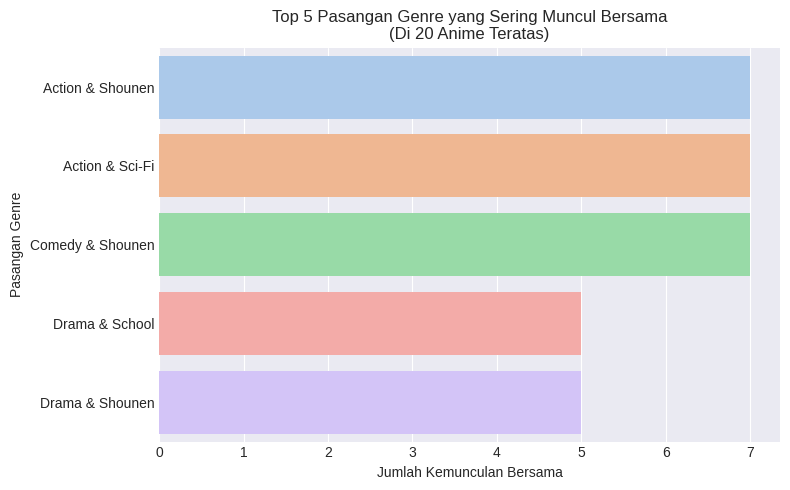

In [40]:
plt.figure(figsize=(8, 5))
sns.barplot(data=pair_df, x='Count', y='Pair', palette='pastel')
plt.title('Top 5 Pasangan Genre yang Sering Muncul Bersama\n(Di 20 Anime Teratas)')
plt.xlabel('Jumlah Kemunculan Bersama')
plt.ylabel('Pasangan Genre')
plt.tight_layout()
plt.show()

In [41]:
#visualisasi genre di top 10 ova
ova_top10 = anime_df[anime_df['type'] == 'OVA'].head(10).copy()

ova_top10['genre'] = ova_top10['genre'].fillna('')
ova_top10['genre_list'] = ova_top10['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

In [42]:
all_ova_genres = sum(ova_top10['genre_list'], [])
genre_counts = Counter(all_ova_genres)


In [43]:
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])
genre_df = genre_df.sort_values(by='Count', ascending=False)

<ipython-input-44-6cafa4604fc3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df, x='Count', y='Genre', palette='pastel')


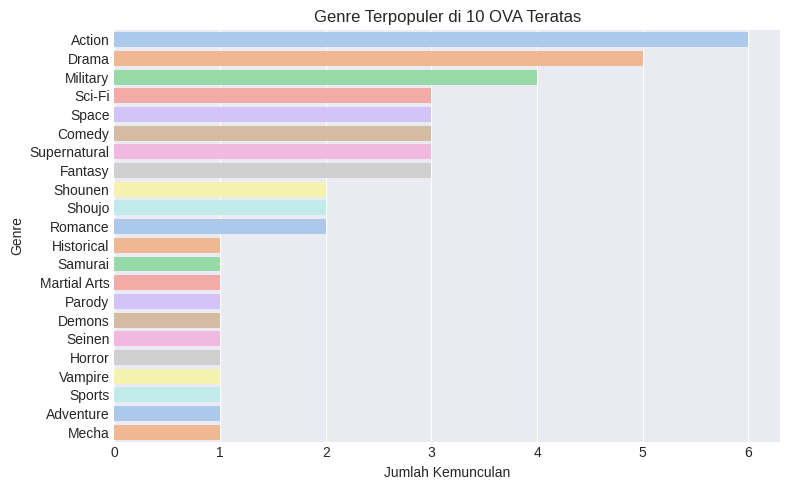

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(data=genre_df, x='Count', y='Genre', palette='pastel')
plt.title('Genre Terpopuler di 10 OVA Teratas')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

**Insight dari Exploratory Data Analysis (EDA) - Dataset Anime**

Analisis eksploratif pada dataset anime memberikan beberapa wawasan menarik mengenai karakteristik dan tren yang ada:

---

**Variasi Genre**

- Terdapat **3265 genre** dalam dataset.
- Contoh kombinasi genre yang ditemukan:
  - `'Drama, Romance, School, Supernatural'`
  - `'Action, Adventure, Drama, Fantasy, Magic'`

---

**Tipe Penayangan Anime**

- Anime dalam dataset ditayangkan dalam berbagai tipe, antara lain:
  - **TV**, **Movie**, **OVA**, **Special**, **ONA**, dan **Music**
- Format **TV** merupakan tipe yang **paling dominan**, terutama dalam **100 anime teratas**.

---

**Popularitas Berdasarkan Jumlah Voters (Members)**

- **"Death Note"** adalah anime dengan **jumlah voters terbanyak**.
- Anime populer lainnya berdasarkan voters:
  - **"Shingeki no Kyojin"**
  - **"Sword Art Online"**
- Hal ini menunjukkan adanya **basis penggemar yang sangat besar** untuk judul-judul tersebut.

---

**Anime dengan Episode Terbanyak**

- 🥇 **"Oyako Club"** – 1818 episode  
- 🥈 **"Doraemon (1979)"** – 1787 episode  
- 🥉 **"Kirin Monoshiri Yakata"** – 1565 episode

---

**Rating Anime**

- Jika dilihat dari **rating mentah**, anime dengan nilai **sempurna (10)**:
  - **"Taka no Tsume 8: Yoshida-kun no X-Files"**, namun hanya dari **13 voters**.
  - Ini menunjukkan bahwa **rating mentah bisa bias** jika jumlah voters terlalu sedikit.
  
Solusi: **Weighted Rating**
- Untuk mengatasi bias tersebut, digunakan pendekatan **Weighted Rating** (menggabungkan rating dan jumlah voters).
  
Anime TV Teratas (berdasarkan Weighted Rating):
1. **Fullmetal Alchemist: Brotherhood**
2. **Gintama°**
3. **Steins;Gate**

Movie Teratas:
1. **Kimi no Na wa.**
2. **Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare**
3. **Koe no Katachi**

OVA Teratas:
1. **Ginga Eiyuu Densetsu**
2. **Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen**
3. **Hellsing Ultimate**

- Terdapat perbedaan urutan antara hasil `qualified.head()` dan `anime_df.head()`, yang menunjukkan **dampak nyata penggunaan Weighted Rating** dibanding peringkat standar dari MAL.

---

**Tren Genre Populer**

- Dalam **20 anime teratas** (berdasarkan ranking MAL), genre yang **paling sering muncul**:
  - **Shounen**
  - **Drama**
  - **Action**
- Pasangan genre yang sering muncul bersama: **"Action & Shounen"**

- Dalam **10 anime OVA teratas**, genre yang dominan:
  - **Action**
  - **Drama**
  - Diikuti oleh: **Military** dan **Sci-Fi**

---

## Data Ratings

In [45]:
#jenis jenis rating
print(rating_df['rating'].unique())

[-1 10  8  6  9  7  3  5  4  1  2]


In [46]:
#mengetahui banyak baris yang merupakan -1
total = len(rating_df)
missing = (rating_df['rating'] == -1).sum()
print(f"{missing} dari {total} baris adalah -1 ({missing/total:.2%})")

1476496 dari 7813737 baris adalah -1 (18.90%)


In [47]:
user_counts = rating_df[rating_df['rating'] != -1]['user_id'].value_counts()
user_counts.describe()

,count
count,69600.000000
mean,91.052313
std,135.764253
min,1.000000
25%,13.000000
50%,45.000000
75%,114.000000
max,3747.000000


In [48]:
#rating terbanyak oleh 10 user teratas berdasarkan index
most_common_rating_per_user = (
    rating_df.groupby('user_id')['rating']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name='most_common_rating')
)

print(most_common_rating_per_user.head(10))

   user_id  most_common_rating
0        1                  -1
1        2                  -1
2        3                   7
3        4                  -1
4        5                   5
5        6                  -1
6        7                   7
7        8                   9
8        9                   8
9       10                  -1


In [49]:
percent_neg1 = (most_common_rating_per_user['most_common_rating'] == -1).mean()
print(f"Persentase user yang paling sering kasih rating -1: {percent_neg1:.2%}")


Persentase user yang paling sering kasih rating -1: 19.57%


In [50]:
rating_std = rating_df[rating_df['rating'] != -1].groupby('user_id')['rating'].std()
print(rating_std.describe())


count    66351.000000
mean         1.231206
std          0.481572
min          0.000000
25%          0.978636
50%          1.217855
75%          1.484448
max          6.363961
Name: rating, dtype: float64


In [51]:
# 10 user dengan rating -1 paling banyak
neg1_counts = rating_df[rating_df['rating'] == -1]['user_id'].value_counts().head(10)

print("Top 10 user yang paling banyak kasih rating -1:")
print(neg1_counts)

Top 10 user yang paling banyak kasih rating -1:
user_id
48766    10227
66021     2315
40604     1720
10283     1629
50264     1614
58343     1593
33285     1577
5705      1511
51216     1446
27364     1424
Name: count, dtype: int64


In [52]:
# 10 user dengan rating 10 paling banyak
rating_10_counts = rating_df[rating_df['rating'] == 10]['user_id'].value_counts().head(10)

print("Top 10 user yang paling banyak kasih rating 10:")
print(rating_10_counts)

Top 10 user yang paling banyak kasih rating 10:
user_id
61110    1463
24310     786
45649     746
30346     722
21160     684
51976     674
32049     671
57620     668
36372     612
66863     601
Name: count, dtype: int64


<ipython-input-53-7ee3b6e3b711>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=valid_ratings, x='rating', palette='pastel')


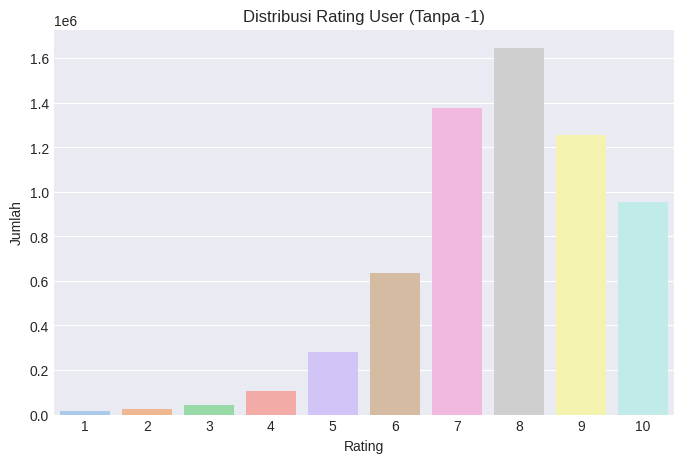

In [53]:
#visualisasi distribuis rating user
valid_ratings = rating_df[rating_df['rating'] != -1]

plt.figure(figsize=(8, 5))
sns.countplot(data=valid_ratings, x='rating', palette='pastel')
plt.title('Distribusi Rating User (Tanpa -1)')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-54-acd80e03c5a8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=valid_ratings['rating'], palette='pastel')


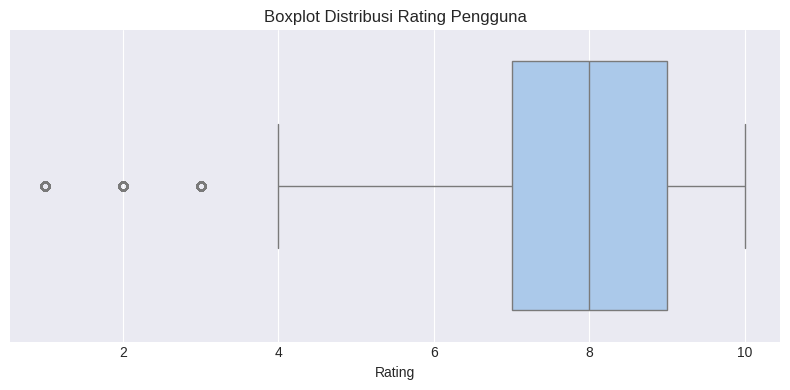

In [54]:
# Boxplot distribusi rating penngguna
plt.figure(figsize=(8, 4))
sns.boxplot(x=valid_ratings['rating'], palette='pastel')
plt.title('Boxplot Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()

In [55]:
#10 anime yang paling banyak masuk watchlist
watchlist_counts = rating_df[rating_df['rating'] == -1]['anime_id'].value_counts().head(10)

print("Top 10 anime yang paling banyak dimasukkan ke watchlist (rating == -1):")
print(watchlist_counts)

Top 10 anime yang paling banyak dimasukkan ke watchlist (rating == -1):
anime_id
1535     5114
16498    4294
11757    4273
226      3978
20       3854
121      3700
6547     3618
1575     3592
8074     3577
199      3493
Name: count, dtype: int64


In [56]:
top_watchlist_anime = watchlist_counts.reset_index()
top_watchlist_anime.columns = ['anime_id', 'watchlist_count']

top_watchlist_anime = top_watchlist_anime.merge(anime_df[['anime_id', 'name']], on='anime_id', how='left')

top_watchlist_anime = top_watchlist_anime.sort_values(by='watchlist_count', ascending=False)
print(top_watchlist_anime[['name', 'watchlist_count']])

                              name  watchlist_count
0                       Death Note             5114
1               Shingeki no Kyojin             4294
2                 Sword Art Online             4273
3                       Elfen Lied             3978
4                           Naruto             3854
5              Fullmetal Alchemist             3700
6                     Angel Beats!             3618
7  Code Geass: Hangyaku no Lelouch             3592
8           Highschool of the Dead             3577
9    Sen to Chihiro no Kamikakushi             3493


In [57]:
#rating matrix
valid_ratings = rating_df[rating_df['rating'] != -1]

n_users = rating_df['user_id'].nunique()
n_anime = rating_df['anime_id'].nunique()

total_possible = n_users * n_anime

total_ratings = len(valid_ratings)

sparsity = 1 - (total_ratings / total_possible)
print(f"Sparsity rating matrix: {sparsity:.2%}")

Sparsity rating matrix: 99.23%


**Insight dari Exploratory Data Analysis (EDA) - Dataset Rating Pengguna**

Analisis eksploratif pada dataset rating pengguna memberikan beberapa wawasan penting mengenai perilaku pengguna dan karakteristik data:

---

**Skala dan Distribusi Rating**

- Terdapat **11 nilai rating unik** yang diberikan oleh pengguna, yaitu: `-1`, `1`, `2`, `3`, `4`, `5`, `6`, `7`, `8`, `9`, dan `10`.
- Sebanyak **1.476.496 dari total 7.813.737 baris data rating** (sekitar **18.90%**) memiliki nilai rating **-1**.
  - Nilai **-1** ini kemungkinan besar mengindikasikan bahwa anime tersebut **ditambahkan ke watchlist** oleh pengguna, namun **belum diberikan skor**.
- Ketika rating **-1 diabaikan**, distribusi rating menunjukkan bahwa pengguna cenderung memberikan **rating tinggi**.
  - Rating **8**, **7**, dan **9** menjadi nilai yang **paling sering diberikan**.

---

**Karakteristik Pengguna (User)**

- Terdapat **3.747 pengguna unik** dalam dataset (berdasarkan pengguna yang memberikan rating selain -1).
- Dari **10 pengguna teratas** (berdasarkan index dataset):
  - Sebagian besar memberikan rating **-1** paling sering, diikuti oleh rating **7**.
  - Sekitar **19.57% pengguna** memiliki **-1** sebagai rating yang paling sering mereka berikan.
- Pengguna dengan **jumlah rating -1 terbanyak** telah menandai **10.227 judul anime** sebagai **watchlist**, menunjukkan **aktivitas tinggi dalam menandai anime untuk ditonton**.
- Di sisi lain, terdapat pengguna yang sangat aktif memberikan **rating 10**, dengan pengguna teratas dalam kategori ini memberikan **rating 10 sebanyak 1.463 kali**.

---

**Anime Populer dalam Watchlist**

- Anime yang paling sering muncul dalam **watchlist pengguna** (dengan rating -1) antara lain:
  - **Death Note**
  - **Shingeki no Kyojin**
  - **Sword Art Online**
- Terdapat korelasi antara anime yang **sering masuk watchlist** dengan anime yang memiliki **jumlah voters tertinggi secara umum**.
  - Ini menunjukkan bahwa **anime populer cenderung menarik minat banyak pengguna** untuk ditonton di kemudian hari.

---

**Sparsity Matrix Rating**

- Nilai **sparsity** dari matriks pengguna-anime adalah **99.23%**.
- Artinya, **hanya sebagian kecil** dari semua kemungkinan pasangan pengguna-anime yang memiliki rating.
- Tingkat sparsity yang tinggi ini merupakan **karakteristik umum dalam dataset sistem rekomendasi**, dan menjadi **tantangan tersendiri dalam pengembangan model rekomendasi**.

---


#Data Cleaning

## Data Anime

In [58]:
#drop baris yang memiliki nilai kosong
anime_df.dropna(inplace=True)

In [59]:
print("Jumlah nilai kosong (NaN):")
print(anime_df.isna().sum())

Jumlah nilai kosong (NaN):
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [60]:
#ubah tipe data episode menjadi number
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

In [61]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  11830 non-null  float64
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 751.1+ KB


In [62]:
#normalisasi teks
anime_df['type'] = anime_df['type'].str.strip().str.title()
anime_df['genre'] = anime_df['genre'].str.strip()

In [63]:
#mengubah kolom genre menjadi berbentuk list
anime_df['genre_list'] = anime_df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

In [64]:
#impute nilai kosong pada episode yang bernilai null menjadi 0
anime_df['episodes'] = anime_df['episodes'].fillna(0).astype(int)

In [65]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_list
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",Tv,64,9.26,793665,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",Tv,51,9.25,114262,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",Tv,24,9.17,673572,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",Tv,51,9.16,151266,"[Action, Comedy, Historical, Parody, Samurai, ..."


**Insight dari Proses Pembersihan Data Anime**

---

**Penanganan Nilai Kosong (Missing Values)**

- Baris yang mengandung **nilai null** pada kolom-kolom krusial seperti **`genre`**, **`type`**, dan **`rating`** dihapus dari dataset.
  - Tindakan ini mengurangi jumlah baris dari **12.294 menjadi 12.017**, yang berarti sekitar **2.25%** data dihapus karena tidak lengkap.
- Untuk kolom **`episodes`**:
  - Nilai kosong setelah konversi tipe data diisi dengan **0**.
  - Hal ini dilakukan agar kolom dapat digunakan dalam analisis numerik, dan angka 0 dapat mengindikasikan jumlah episode yang **tidak diketahui** atau memang **nol** (contohnya untuk film pendek).

---
**Konversi Tipe Data**

- Kolom **`episodes`**, yang awalnya bertipe **objek/string** karena ada nilai seperti `"Unknown"`, diubah menjadi **tipe numerik (`int`)**.
  - Nilai yang tidak bisa dikonversi (misal `"Unknown"`) diubah menjadi **NaN**, kemudian diimputasi dengan **0**.

---

**Normalisasi Teks**

- Dilakukan normalisasi format teks agar konsisten dan bersih:
  - Menghilangkan **spasi berlebih** dan mengubah teks menjadi **title case** (misal: "tv" menjadi "Tv").
  - Menghapus spasi berlebih di awal dan akhir string, untuk memastikan penulisan genre **konsisten**.
---

**Transformasi Fitur Genre**

- Kolom **`genre`** yang sebelumnya berupa **string dengan genre dipisahkan koma**, diubah menjadi **format list** pada kolom baru bernama **`genre_list`**.
  - Contoh: `"Action, Adventure, Drama"` → `['Action', 'Adventure', 'Drama']`
  - Transformasi ini memudahkan proses seperti **ekstraksi fitur genre individual** pada metode **content-based filtering**.

---


## Data Rating

In [66]:
#drop baris dengan rating -1 karena itu bukan rating valid
cf_df = rating_df[rating_df['rating'] != -1].copy()

In [67]:
#Drop user yang memberi rating 1-2 judul
user_counts = cf_df['user_id'].value_counts()

active_users = user_counts[user_counts >=10].index

cf_df = cf_df[cf_df['user_id'].isin(active_users)]

In [68]:
cf_df.shape

(6278359, 3)

In [69]:
print(f"Jumlah baris cf_df sebelum drop duplicates spesifik: {len(cf_df)}")

cf_df.drop_duplicates(subset=['user_id', 'anime_id'], keep='last', inplace=True)
print(f"Jumlah baris cf_df setelah drop duplicates spesifik: {len(cf_df)}")

Jumlah baris cf_df sebelum drop duplicates spesifik: 6278359
Jumlah baris cf_df setelah drop duplicates spesifik: 6278352


In [70]:
cf_df.duplicated().sum()

np.int64(0)

In [71]:
#drop anime yang hanya di rating oleh 1-2 user
anime_counts = cf_df['anime_id'].value_counts()
popular_anime = anime_counts[anime_counts >= 5].index
cf_df = cf_df[cf_df['anime_id'].isin(popular_anime)]


In [72]:
cf_df.shape

(6274555, 3)

**Insight dari Proses Pembersihan Data Rating**
---

**Penghapusan Rating Tidak Valid**

- Baris dengan nilai **rating -1** dihapus dari dataset.
  - Nilai ini dianggap **tidak valid** atau mengindikasikan **anime yang hanya dimasukkan ke watchlist** tanpa skor penilaian eksplisit.
  - Rating eksplisit sangat penting dalam collaborative filtering, karena model ini mempelajari **preferensi berdasarkan skor yang diberikan pengguna**.

---

**Filtering Pengguna Tidak Aktif**

- Pengguna yang memberikan rating pada **kurang dari 10 anime** dihapus.
  - Tujuannya untuk mengurangi **noise** dari pengguna yang tidak cukup aktif.
  - Pengguna aktif dianggap lebih mewakili pola preferensi yang **konsisten dan berguna** bagi pemodelan.

---

**Penanganan Data Duplikat**

- **Baris duplikat** berdasarkan kombinasi `user_id` dan `anime_id` dihapus.
  - Duplikat diatasi dengan cara mempertahankan entri terakhir (`keep='last'`).
  - Ini memastikan **satu pengguna hanya memberikan satu rating unik** untuk setiap anime, menghindari konflik nilai rating ganda.

---

**Filtering Anime Kurang Populer**

- Anime yang hanya dirating oleh **kurang dari 5 pengguna** dihapus dari dataset.
  - Hal ini dilakukan untuk menghindari item yang terlalu **jarang** sehingga **tidak cukup data** untuk mendeteksi pola preferensi pengguna.
  - Juga membantu mengurangi **sparsity** dan meningkatkan efektivitas model.

---

**Dampak pada Volume Data**

- Setelah semua proses pembersihan (rating -1, filtering pengguna, duplikat, dan anime langka), jumlah baris data berkurang menjadi **6.274.555** baris.
  - Sebelumnya, setelah penghapusan rating -1 dan duplikat, data tersisa **6.278.359** baris.
  - Ini menunjukkan bahwa filtering tambahan memberikan pengurangan data yang relatif kecil namun berdampak penting terhadap **kualitas dan densitas interaksi**.

---


# Content-Based Filtering

### Data Preparation(lanjutan)

In [73]:
#untuk content-based, dibutuhkan id, name, dan fitur konten
content_df = anime_df[['anime_id', 'name', 'genre_list']].copy()
content_df.dropna(subset=['genre_list'], inplace=True) # Pastikan genre_list tidak ada yang NaN

print(f"Jumlah anime setelah persiapan untuk Content-Based: {len(content_df)}")
content_df.head()

Jumlah anime setelah persiapan untuk Content-Based: 12017


,anime_id,name,genre_list
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ..."


### feature engineering

In [74]:
#mengubah list genre menjadi string yang dipisahkan spasi
content_df['genre_str'] = content_df['genre_list'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')


In [75]:
def preprocess_genre_item(genre_item):
    """
    Membersihkan satu item genre:
    1. Ubah ke huruf kecil.
    2. Ganti semua karakter non-alfanumerik dengan underscore.
    3. Hilangkan underscore berlebihan di awal/akhir atau underscore ganda.
    """
    if not isinstance(genre_item, str):
        return ""
    # Ubah ke huruf kecil
    processed_item = genre_item.lower()
    # Ganti semua karakter non-alfanumerik dengan underscore tunggal
    processed_item = re.sub(r'[^a-z0-9]+', '_', processed_item)
    # Hapus underscore di awal atau akhir jika ada
    processed_item = processed_item.strip('_')
    return processed_item

def preprocess_genre_list(genre_list):
    """
    Memproses list genre, menerapkan preprocess_genre_item ke setiap genre.
    """
    if isinstance(genre_list, list):
        return [preprocess_genre_item(genre) for genre in genre_list if genre.strip()] # Pastikan genre tidak string kosong
    return []

In [76]:
# Terapkan fungsi pra-pemrosesan yang direvisi
content_df['genre_tokens'] = content_df['genre_list'].apply(preprocess_genre_list)

# Sekarang, gabungkan genre_tokens_revised menjadi string yang dipisahkan spasi
content_df['genre_str'] = content_df['genre_tokens'].apply(lambda x: ' '.join(x))


In [77]:
# Inisialisasi TfidfVectorizer
# lowercase=False karena kita sudah melakukan lowercase di pra-pemrosesan
tfidf_vectorizer = TfidfVectorizer(lowercase=False)

# Melakukan fit dan transform pada data genre_str_revised
tfidf_matrix = tfidf_vectorizer.fit_transform(content_df['genre_str'])

In [78]:
# Melihat bentuk matriks TF-IDF
print(f"\nBentuk matriks TF-IDF (setelah proses genre): {tfidf_matrix.shape}")

# Melihat beberapa nama fitur (genre) yang telah di-vectorize
print("\nContoh nama fitur (genre) setelah diproses:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(list(feature_names)[:30])



Bentuk matriks TF-IDF (setelah proses genre): (12017, 43)

Contoh nama fitur (genre) setelah diproses:
['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons', 'drama', 'ecchi', 'fantasy', 'game', 'harem', 'hentai', 'historical', 'horror', 'josei', 'kids', 'magic', 'martial_arts', 'mecha', 'military', 'music', 'mystery', 'parody', 'police', 'psychological', 'romance', 'samurai', 'school', 'sci_fi', 'seinen']


**Insight Data Preparation dan Feature Engineering untuk Content-Based Filtering**

Tahapan ini bertujuan untuk mempersiapkan data anime agar dapat digunakan dalam model rekomendasi berbasis konten, dengan fokus utama pada fitur genre.

1.  **Pembuatan DataFrame Khusus Konten:**
    * Sebuah DataFrame baru bernama `content_df` dibuat. DataFrame ini hanya berisi kolom-kolom yang relevan untuk *content-based filtering*, yaitu `anime_id`, `name` (judul anime), dan `genre_list` (daftar genre per anime yang sudah diproses sebelumnya).
    * Baris yang tidak memiliki informasi `genre_list` (nilai NaN) dihapus untuk memastikan setiap anime memiliki fitur konten yang akan diproses.

2.  **Pra-pemrosesan Fitur Genre:**
    * Untuk memastikan setiap genre, termasuk yang multi-kata atau menggunakan tanda hubung (seperti "Slice of Life" atau "Sci-Fi"), diperlakukan sebagai satu unit fitur (token) yang unik, dilakukan beberapa langkah pra-pemrosesan:
        * Dibuat fungsi `preprocess_genre_item` yang bertugas untuk membersihkan setiap item genre individual. Proses pembersihan ini meliputi:
            1.  Mengubah teks genre menjadi huruf kecil (lowercase) untuk konsistensi.
            2.  Mengganti semua karakter non-alfanumerik (seperti spasi, tanda hubung, dll.) dengan karakter underscore (`_`).
            3.  Menghilangkan underscore yang mungkin berlebihan di awal atau akhir string genre.
        * Dibuat fungsi `preprocess_genre_list` yang menerapkan `preprocess_genre_item` ke setiap genre dalam `genre_list` untuk setiap anime. Hasilnya adalah daftar token genre yang sudah bersih (misalnya, `['slice_of_life', 'comedy', 'sci_fi']`).
    * Kolom baru `genre_tokens` ditambahkan ke `content_df` untuk menyimpan daftar token genre yang telah diproses ini.
    * Selanjutnya, token-token genre dalam `genre_tokens` digabungkan kembali menjadi satu string tunggal per anime, dengan setiap token genre dipisahkan oleh spasi. String gabungan ini disimpan dalam kolom baru `genre_str`.

3.  **Representasi Fitur dengan TF-IDF (Term Frequency-Inverse Document Frequency):**
    * `TfidfVectorizer` dari pustaka `sklearn` digunakan untuk mengubah data teks `genre_str` menjadi representasi numerik dalam bentuk matriks TF-IDF.
    * Proses `fit_transform` diterapkan pada kolom `genre_str`.
    * Matriks TF-IDF yang dihasilkan memiliki bentuk **(12017, 43)**. Ini berarti:
        * Terdapat **12.017 anime** yang diproses dan direpresentasikan sebagai vektor fitur.
        * Terdapat **43 fitur genre unik** yang berhasil diidentifikasi dan digunakan sebagai dimensi dalam representasi vektor (misalnya, 'action', 'adventure', 'cars', 'comedy', 'slice\_of\_life', 'sci\_fi', dll.).


### Modelling

In [79]:
def calculate_cosine_similarity(matrix):
    """
    Menghitung matriks cosine similarity dari matriks input.
    Args:
        matrix (scipy.sparse.csr_matrix atau np.ndarray): Matriks fitur (misalnya, TF-IDF).
    Returns:
        np.ndarray: Matriks cosine similarity.
    """
    cosine_sim_matrix = cosine_similarity(matrix, matrix)
    return cosine_sim_matrix

In [80]:
# Fungsi calculate_cosine_similarity tetap sama
cosine_sim_matrix = calculate_cosine_similarity(tfidf_matrix)
print(f"\nBentuk matriks Cosine Similarity: {cosine_sim_matrix.shape}")


Bentuk matriks Cosine Similarity: (12017, 12017)


In [81]:
def get_content_based_recommendations(anime_title, df, similarity_matrix, top_n=10):
    """
    Memberikan rekomendasi anime berdasarkan kemiripan konten.
    Args:
        anime_title (str): Judul anime yang dicari rekomendasinya.
        df (pd.DataFrame): DataFrame yang berisi 'anime_id', 'name', dan fitur lainnya.
                           Harus memiliki indeks yang sesuai dengan matriks kemiripan.
        similarity_matrix (np.ndarray): Matriks cosine similarity.
        top_n (int): Jumlah rekomendasi yang diinginkan.
    Returns:
        pd.DataFrame: DataFrame berisi anime yang direkomendasikan.
    """
    df_indexed = df.reset_index(drop=True)

    # Buat Series untuk mapping judul (lowercase) ke indeks
    indices = pd.Series(df_indexed.index, index=df_indexed['name'].str.lower())

    # Ubah judul input ke lowercase
    anime_title_lower = anime_title.lower()

    try:
        idx = indices[anime_title_lower]
    except KeyError:
        # Coba cari judul yang paling mirip jika tidak ada kecocokan persis
        # Untuk sekarang, kita kembalikan pesan tidak ditemukan
        print(f"Judul '{anime_title}' tidak ditemukan. Mencari kecocokan parsial (case-insensitive)...")
        partial_matches = df_indexed[df_indexed['name'].str.lower().str.contains(anime_title_lower)]
        if not partial_matches.empty:
            best_match_title = partial_matches['name'].iloc[0]
            print(f"Apakah maksud Anda: '{best_match_title}'? Menampilkan rekomendasi untuk ini.")
            idx = indices[best_match_title.lower()]
        else:
            return f"Anime dengan judul '{anime_title}' tidak ditemukan."


    # Mendapatkan skor kemiripan dari semua anime dengan anime yang dipilih
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Mengurutkan anime berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil skor dari N anime paling mirip (tidak termasuk anime itu sendiri, jadi N+1)
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks anime yang direkomendasikan
    anime_indices = [i[0] for i in sim_scores]

    # Mengembalikan N anime paling mirip
    return df_indexed.iloc[anime_indices][['name', 'genre_list', 'anime_id']]

In [82]:
target_anime_title = "Shigatsu wa Kimi no Uso"

# Ubah judul target dan kolom nama di DataFrame menjadi lowercase untuk pengecekan
target_anime_title_lower_check = target_anime_title.lower()

if 'name_lower' not in content_df.columns:
    content_df['name_lower'] = content_df['name'].str.lower()

if target_anime_title_lower_check in content_df['name_lower'].values:
    recommendations = get_content_based_recommendations(
        target_anime_title,
        content_df,
        cosine_sim_matrix,
        top_n=10
    )

    # Periksa apakah hasilnya adalah string (pesan error) atau DataFrame
    if isinstance(recommendations, str):
        print(recommendations)
    else:
        # Buat DataFrame baru untuk tampilan agar tidak mengubah DataFrame asli
        recommendations_display = recommendations.copy()

        # Format kolom 'genre_list' menjadi string yang rapi
        recommendations_display['genre_list'] = recommendations_display['genre_list'].apply(
            lambda genres: ', '.join([genre.replace('_', ' ') for genre in genres])
        )

        print(f"\nRekomendasi untuk '{target_anime_title}':")
        # Tampilkan kolom yang sudah diformat
        print(recommendations_display[['name', 'genre_list']])
else:
    print(f"\nAnime '{target_anime_title}' tidak ditemukan dalam dataset yang telah diproses (pengecekan awal).")
    if not content_df.empty:
        print("Mencoba dengan judul acak dari dataset sebagai contoh...")
        example_anime_title = content_df['name'].sample(1).iloc[0]
        print(f"Mencoba rekomendasi untuk anime acak: '{example_anime_title}'")
        recommendations = get_content_based_recommendations(
            example_anime_title,
            content_df,
            cosine_sim_matrix,
            top_n=10
        )
        if isinstance(recommendations, str):
            print(recommendations)
        else:
            recommendations_display_random = recommendations.copy()
            recommendations_display_random['genre_list'] = recommendations_display_random['genre_list'].apply(
                lambda genres: ', '.join([genre.replace('_', ' ') for genre in genres])
            )
            print(f"\nRekomendasi untuk '{example_anime_title}' (dengan genre diproses revisi, format rapi):")
            print(recommendations_display_random[['name', 'genre_list']])


Rekomendasi untuk 'Shigatsu wa Kimi no Uso':
                                                   name  \
5312                       D.C.III: Da Capo III Special   
2191               Kimi no Iru Machi: Tasogare Kousaten   
2211             Shinkyoku Soukai Polyphonica Crimson S   
3507                       Shinkyoku Soukai Polyphonica   
256                                 Hibike! Euphonium 2   
492                                   Hibike! Euphonium   
1564                 Hibike! Euphonium: Kakedasu Monaka   
8322  Chiisana Love Letter: Mariko to Nemunoki no Ko...   
4046                       Aru Machi Kado no Monogatari   
4221                                True Tears Epilogue   

                                  genre_list  
5312           Drama, Music, Romance, School  
2191         Drama, Romance, School, Shounen  
2211  Drama, Fantasy, Music, Romance, School  
3507  Drama, Fantasy, Music, Romance, School  
256                     Drama, Music, School  
492                   

## Evaluation

In [83]:
def calculate_average_precision(recommended_ids, relevant_ids_for_comparison, k):
    """Menghitung Average Precision (AP) untuk satu query/pengguna."""
    hits = 0
    precision_sum = 0.0

    # Batasi rekomendasi hingga k
    actual_k = min(k, len(recommended_ids))
    if actual_k == 0:
        return 0.0

    for i in range(actual_k):
        if recommended_ids[i] in relevant_ids_for_comparison:
            hits += 1
            precision_sum += hits / (i + 1) # Presisi pada posisi ini

    if not relevant_ids_for_comparison: # Jika tidak ada item relevan untuk dibandingkan (setelah input dihilangkan)
        return 0.0 # atau 1.0 jika tidak ada rekomendasi dan tidak ada yang relevan (tergantung definisi)
    if hits == 0:
        return 0.0

    return precision_sum / min(len(relevant_ids_for_comparison), k) # Normalisasi bisa dengan jumlah item relevan atau k

In [84]:
def evaluate_content_based_metrics_for_user(user_id, cf_df, content_df, similarity_matrix, get_recommendations_func, k=10, rating_threshold=7):
    """
    Mengevaluasi Precision@K, AP, dan skor untuk NDCG untuk Content-Based Filtering untuk satu pengguna.
    """
    user_rated_anime = cf_df[cf_df['user_id'] == user_id]
    highly_rated_by_user_df = user_rated_anime[user_rated_anime['rating'] >= rating_threshold]

    if len(highly_rated_by_user_df) < 2:
        return None, None, None, None # Precision, AP, y_true_ndcg, y_pred_ndcg

    input_anime_row = highly_rated_by_user_df.sample(1).iloc[0]
    input_anime_id = input_anime_row['anime_id']

    input_anime_details = content_df[content_df['anime_id'] == input_anime_id]
    if input_anime_details.empty:
        return None, None, None, None
    input_anime_title = input_anime_details['name'].iloc[0]

    recommendations_df = get_recommendations_func(input_anime_title, content_df, similarity_matrix, top_n=k)

    if isinstance(recommendations_df, str):
        return 0.0, 0.0, np.array([0]), np.array([0]) # Anggap 0 jika tidak ada rekomendasi valid

    recommended_anime_ids = recommendations_df['anime_id'].tolist()

    if not recommended_anime_ids:
        return 0.0, 0.0, np.array([0]), np.array([0])

    # Untuk Precision dan AP
    relevant_anime_ids_for_comparison = highly_rated_by_user_df[highly_rated_by_user_df['anime_id'] != input_anime_id]['anime_id'].tolist()

    hits = 0
    for rec_id in recommended_anime_ids:
        if rec_id in relevant_anime_ids_for_comparison:
            hits += 1

    precision_at_k_score = hits / len(recommended_anime_ids)
    average_precision_score = calculate_average_precision(recommended_anime_ids, relevant_anime_ids_for_comparison, k)

    # Untuk NDCG: y_true adalah skor relevansi sebenarnya (rating), y_pred adalah skor yang diberikan model
    # Dalam content-based murni, kita tidak punya skor prediksi relevansi dari model untuk ranking (hanya similarity)
    # Jadi kita akan menggunakan urutan rekomendasi sebagai skor prediksi (item di awal lebih tinggi)
    # dan rating aktual sebagai true relevance.

    # Buat y_true untuk NDCG: rating aktual dari item yang direkomendasikan (0 jika tidak dirating pengguna / di bawah threshold)
    true_relevances = []
    # Buat y_score untuk NDCG: skor buatan berdasarkan ranking (lebih tinggi untuk yang di awal)
    # Ini adalah penyederhanaan karena CB tidak menghasilkan skor prediksi per pengguna.
    # Atau, kita bisa gunakan skor cosine similarity dari rekomendasi, tapi ini kemiripan ke item input, bukan ke user.
    # Untuk kesederhanaan, kita gunakan relevansi biner (1 jika dirating tinggi oleh user, 0 jika tidak)
    # dan urutan rekomendasi (skor lebih tinggi untuk yang di awal)

    y_true_ndcg = []
    y_score_ndcg = [] # Skor berdasarkan ranking, item di awal dapat skor lebih tinggi

    # Ambil semua anime yang dirating oleh user ini untuk cek relevansi
    user_all_rated_map = dict(zip(user_rated_anime['anime_id'], user_rated_anime['rating']))

    for i, rec_id in enumerate(recommended_anime_ids):
        # Skor relevansi aktual: rating dari pengguna, atau 0 jika tidak dirating tinggi atau tidak ada.
        # Kita gunakan rating aktual sebagai relevansi untuk NDCG
        actual_rating = user_all_rated_map.get(rec_id, 0)
        y_true_ndcg.append(actual_rating)
        y_score_ndcg.append(k - i) # Skor buatan, item di rank 1 dapat skor k, rank k dapat skor 1

    # Pastikan y_true_ndcg dan y_score_ndcg tidak kosong dan 2D
    if not y_true_ndcg: # Jika tidak ada item direkomendasikan yang pernah dirating user
        ndcg_at_k_score = 0.0 # Atau None, jika tidak ada overlap sama sekali
    else:
        # ndcg_score mengharapkan input 2D ([[]])
        ndcg_at_k_score = ndcg_score(np.asarray([y_true_ndcg]), np.asarray([y_score_ndcg]), k=k)

    return precision_at_k_score, average_precision_score, ndcg_at_k_score, len(recommended_anime_ids)


In [85]:
# ----- Contoh Penggunaan Evaluasi untuk Beberapa Pengguna (dengan MAP dan NDCG) -----
unique_user_ids_in_cf = cf_df['user_id'].unique()
num_users_to_evaluate_cb = min(100, len(unique_user_ids_in_cf)) # Kurangi jika terlalu lama

if num_users_to_evaluate_cb > 0:
    sampled_user_ids_for_cb_eval = random.sample(list(unique_user_ids_in_cf), num_users_to_evaluate_cb)

    all_precisions_cb = []
    all_average_precisions_cb = []
    all_ndcgs_cb = []

    print(f"Mengevaluasi Content-Based Filtering untuk {num_users_to_evaluate_cb} pengguna...")

    if 'name_lower' not in content_df.columns:
        content_df_for_eval = content_df.copy()
        content_df_for_eval['name_lower'] = content_df_for_eval['name'].str.lower()
    else:
        content_df_for_eval = content_df.copy()

    evaluated_users_count = 0
    for i, user_id_eval in enumerate(sampled_user_ids_for_cb_eval):
        if (i + 1) % 10 == 0:
             print(f"Evaluasi Pengguna {i+1}/{num_users_to_evaluate_cb}: ID {user_id_eval}")

        precision, avg_precision, ndcg, num_recs = evaluate_content_based_metrics_for_user(
            user_id_eval,
            cf_df,
            content_df_for_eval,
            cosine_sim_matrix,
            get_content_based_recommendations,
            k=10,
            rating_threshold=7
        )

        if precision is not None and avg_precision is not None and ndcg is not None:
            all_precisions_cb.append(precision)
            all_average_precisions_cb.append(avg_precision)
            all_ndcgs_cb.append(ndcg)
            evaluated_users_count +=1

    if evaluated_users_count > 0:
        mean_precision_at_10_cb = np.mean(all_precisions_cb)
        map_at_10_cb = np.mean(all_average_precisions_cb)
        mean_ndcg_at_10_cb = np.mean(all_ndcgs_cb)

        print(f"\nMean Precision@10 untuk Content-Based Filtering (pada {evaluated_users_count} pengguna): {mean_precision_at_10_cb:.4f}")
        print(f"MAP@10 untuk Content-Based Filtering (pada {evaluated_users_count} pengguna): {map_at_10_cb:.4f}")
        print(f"Mean NDCG@10 untuk Content-Based Filtering (pada {evaluated_users_count} pengguna): {mean_ndcg_at_10_cb:.4f}")
    else:
        print("\nTidak ada pengguna yang bisa dievaluasi untuk Content-Based Filtering dengan kriteria yang diberikan.")
else:
    print("Tidak ada pengguna unik di cf_df untuk dievaluasi.")


Mengevaluasi Content-Based Filtering untuk 100 pengguna...
Evaluasi Pengguna 10/100: ID 18240
Evaluasi Pengguna 20/100: ID 67037
Evaluasi Pengguna 30/100: ID 68649
Evaluasi Pengguna 40/100: ID 28230
Evaluasi Pengguna 50/100: ID 20572
Evaluasi Pengguna 60/100: ID 8006
Evaluasi Pengguna 70/100: ID 48828
Evaluasi Pengguna 80/100: ID 1604
Evaluasi Pengguna 90/100: ID 6580
Evaluasi Pengguna 100/100: ID 27805

Mean Precision@10 untuk Content-Based Filtering (pada 100 pengguna): 0.0770
MAP@10 untuk Content-Based Filtering (pada 100 pengguna): 0.0422
Mean NDCG@10 untuk Content-Based Filtering (pada 100 pengguna): 0.4375


**Insight Modeling Content-Based Filtering**

Setelah tahap persiapan fitur konten (genre) selesai, langkah berikutnya adalah membangun model rekomendasi berbasis konten. Pendekatan ini merekomendasikan item (anime) yang mirip dengan item yang disukai pengguna berdasarkan atribut kontennya.

1.  **Perhitungan Matriks Kemiripan (Cosine Similarity):**
    * Matriks TF-IDF yang telah dibuat (merepresentasikan setiap anime sebagai vektor fitur genre) digunakan sebagai input untuk menghitung kemiripan antar anime.
    * Metode `cosine_similarity` dari `sklearn.metrics.pairwise` diterapkan pada matriks TF-IDF tersebut.
    * Hasilnya adalah sebuah matriks kemiripan kosinus dengan bentuk **(12017, 12017)**. Ini berarti matriks tersebut menyimpan skor kemiripan antara setiap pasang dari 12.017 anime yang ada dalam dataset yang diproses.
    * Setiap sel `[i, j]` dalam matriks ini berisi skor kemiripan antara anime `i` dan anime `j`.

2.  **Implementasi Fungsi Rekomendasi (`get_content_based_recommendations`):**
    * Sebuah fungsi dikembangkan untuk menghasilkan rekomendasi berdasarkan judul anime yang diberikan sebagai input.
    * Fungsi ini bekerja dengan cara:
        * Mencari indeks dari anime input dalam DataFrame.
        * Mengambil baris skor kemiripan anime tersebut dari matriks `cosine_sim_matrix`.
        * Mengurutkan semua anime lain berdasarkan skor kemiripan tertinggi terhadap anime input.
        * Mengembalikan N anime teratas sebagai rekomendasi, tidak termasuk anime input itu sendiri.
3.  **Contoh Hasil Rekomendasi:**
    * Sebagai contoh, ketika fungsi dijalankan dengan input anime "Shigatsu wa Kimi no Uso", sistem berhasil memberikan daftar rekomendasi.
    * Beberapa anime yang direkomendasikan antara lain:
        * "D.C.III: Da Capo III Special" (genre: Drama, Music, Romance, School)
        * "Kimi no Iru Machi: Tasogare Kousaten" (genre: Drama, Romance, School, Shounen)
        * "Shinkyoku Soukai Polyphonica Crimson S" (genre: Drama, Fantasy, Music, Romance, School)
    * Rekomendasi ini didasarkan pada kemiripan genre dengan "Shigatsu wa Kimi no Uso".
4.  **Evaluasi**
    * Evaluasi dilakukan dengan menyimulasikan skenario pengguna untuk memberikan gambaran kuantitatif. Untuk 100 pengguna sampel, satu anime yang mereka sukai (rating >= 7) dipilih sebagai input. Rekomendasi top-10 berdasarkan genre kemudian dibandingkan dengan anime lain yang juga disukai pengguna tersebut.
    * Hasil metrik evaluasi yang didapatkan adalah:
      * Mean Precision@10: **0.0770**
      * MAP@10 (Mean Average Precision): **0.0422**
      * Mean NDCG@10 (Normalized Discounted Cumulative Gain): 0.4375
    * Skor Precision@10 dan MAP@10 yang relatif rendah menunjukkan bahwa keselarasan antara kemiripan genre murni dengan preferensi rating historis pengguna untuk item lain tidak terlalu tinggi dalam simulasi ini
    * Skor NDCG@10 sebesar 0.4375 mengindikasikan kualitas ranking yang sedang jika dibandingkan dengan relevansi rating pengguna.




# Collaborative

In [ ]:
#    Dataset ini akan menangani pembuatan mapping dari user_id asli dan anime_id asli ke ID internal yang digunakan oleh LightFM (integer mulai dari 0).
dataset = Dataset()

In [ ]:
#Fit dataset dengan user ID dan item ID unik dari cf_df
#Ini akan membangun kamus internal untuk user dan item.
dataset.fit(
    users=cf_df['user_id'].unique(),
    items=cf_df['anime_id'].unique()
)

In [ ]:
# Cek jumlah user dan item yang dikenali oleh dataset
num_users_lightfm, num_items_lightfm = dataset.interactions_shape()
print(f'Num users: {num_users_lightfm}, num_items: {num_items_lightfm}.')

Num users: 55118, num_items: 8025.


In [ ]:
#Membangun matriks interaksi dan bobot (rating)
#  menggunakan generator expression untuk efisiensi.
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    (row['user_id'], row['anime_id'], row['rating'])
    for index, row in cf_df.iterrows()
)

In [ ]:
# Matriks ini dalam format COO (Coordinate), yang efisien untuk data sparse.
print("Bentuk matriks interaksi:", interactions_matrix.shape)
print("Bentuk matriks bobot (rating):", weights_matrix.shape)


Bentuk matriks interaksi: (55118, 8025)
Bentuk matriks bobot (rating): (55118, 8025)


In [ ]:
#Mendapatkan mapping ID (penting untuk interpretasi hasil nanti)
# Ini adalah mapping dari ID asli ke ID internal LightFM
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()


In [ ]:
# Kita juga butuh mapping balik dari ID internal LightFM ke ID anime asli
# untuk menampilkan nama anime dalam rekomendasi
item_id_to_anime_id_map = {v: k for k, v in item_id_map.items()}

In [ ]:
#Membagi data menjadi set training dan testing
#LightFM menyediakan fungsi untuk ini yang menjaga agar user/item ada di kedua set.
train_interactions, test_interactions = random_train_test_split(
    interactions_matrix,
    test_percentage=0.2,
    random_state=np.random.RandomState(42)
)

train_weights, test_weights = random_train_test_split(
    weights_matrix,
    test_percentage=0.2,
    random_state=np.random.RandomState(42)
)

In [ ]:
print("Bentuk matriks interaksi train:", train_interactions.shape)
print("Bentuk matriks interaksi test:", test_interactions.shape)
print("Bentuk matriks bobot train:", train_weights.shape)
print("Bentuk matriks bobot test:", test_weights.shape)

Bentuk matriks interaksi train: (55118, 8025)
Bentuk matriks interaksi test: (55118, 8025)
Bentuk matriks bobot train: (55118, 8025)
Bentuk matriks bobot test: (55118, 8025)


**Insight Data Preparation untuk Collaborative Filtering dengan LightFM**

Tahapan ini berfokus pada persiapan data rating pengguna (`cf_df`) untuk digunakan dengan library LightFM, yang merupakan langkah awal dalam membangun model rekomendasi collaborative filtering.

1.  **Pembuatan Objek Dataset LightFM:**
    * Sebuah objek `Dataset` dari library `lightfm.data` diinisialisasi. Objek ini berfungsi untuk mengelola dan memetakan ID pengguna dan item asli ke ID internal yang digunakan oleh LightFM (berupa integer yang dimulai dari 0).

2.  **Fitting Dataset dengan User dan Item Unik:**
    * Metode `dataset.fit()` dipanggil dengan memberikan daftar `user_id` unik dan `anime_id` unik yang berasal dari DataFrame `cf_df`. Proses ini memungkinkan objek `Dataset` untuk membangun kamus internal yang berisi semua pengguna dan item yang akan dipertimbangkan dalam model.
    * Setelah proses fitting, jumlah pengguna dan item unik yang dikenali oleh dataset LightFM diperiksa.

3.  **Pembangunan Matriks Interaksi dan Bobot (Rating):**
    * Metode `dataset.build_interactions()` digunakan untuk membuat matriks interaksi antara pengguna dan item.
    * Data input untuk metode ini adalah tupel `(user_id, anime_id, rating)` yang diambil dari setiap baris di `cf_df`, menggunakan *generator expression* untuk efisiensi memori.
    * Proses ini menghasilkan dua matriks utama:
        * `interactions_matrix`: Matriks sparse (dalam format COO - Coordinate) yang menandai adanya interaksi antara pengguna dan item (biasanya dengan nilai 1).
        * `weights_matrix`: Matriks sparse yang berisi nilai rating aktual sebagai bobot untuk setiap interaksi yang ada di `interactions_matrix`.
    * Bentuk (shape) dari kedua matriks ini diverifikasi untuk memastikan konsistensi dengan jumlah pengguna dan item yang telah di-fit.

4.  **Pemetaan ID:**
    * Fungsi `dataset.mapping()` digunakan untuk mendapatkan kamus pemetaan yang dibuat oleh LightFM. Kamus ini berisi mapping dari `user_id` asli ke ID internal pengguna, dan `anime_id` asli ke ID internal item (anime).
    * Selain itu, dibuat juga kamus pemetaan balik (`item_id_to_anime_id_map`) dari ID internal item LightFM kembali ke `anime_id` asli. Pemetaan balik ini krusial untuk tahap selanjutnya, yaitu saat menampilkan rekomendasi agar bisa menyajikan nama anime asli, bukan ID internal model.

5.  **Pembagian Dataset (Train-Test):**
    * Untuk keperluan evaluasi model, data interaksi dan bobot dibagi menjadi set pelatihan (train) dan set pengujian (test).
    * Fungsi `random_train_test_split` dari `lightfm.cross_validation` digunakan untuk melakukan pembagian ini. Pembagian dilakukan dengan proporsi 20% data untuk set pengujian dan menggunakan `random_state` untuk memastikan hasil pembagian yang reproduktif.
    * Baik `interactions_matrix` maupun `weights_matrix` dibagi menggunakan `random_state` yang sama untuk menjaga konsistensi antara interaksi dan bobotnya di kedua set data.
    * Bentuk dari matriks-matriks hasil pembagian (train dan test) kemudian dicetak untuk verifikasi.


###modelling

In [ ]:
model_lightfm = LightFM(
    no_components=50,
    loss='warp',
    learning_schedule='adagrad',
    random_state=42
)

In [ ]:
print("Melatih model LightFM...")
model_lightfm.fit(
    interactions=train_interactions,
    sample_weight=train_weights,
    epochs=20,
    num_threads=10
)
print("Pelatihan model selesai.")

Melatih model LightFM...
Pelatihan model selesai.


In [ ]:
# Evaluasi pada data training
# (Untuk melihat seberapa baik model fit dengan data yang dilihatnya)
train_precision = precision_at_k(
    model_lightfm,
    train_interactions,
    k=10
).mean()

train_recall = recall_at_k(
    model_lightfm,
    train_interactions,
    k=10
).mean()

train_auc = auc_score(
    model_lightfm,
    train_interactions
).mean()

print(f"Training Precision@10: {train_precision:.4f}")
print(f"Training Recall@10: {train_recall:.4f}")
print(f"Training AUC: {train_auc:.4f}")

Training Precision@10: 0.6152
Training Recall@10: 0.1515
Training AUC: 0.9857


In [ ]:
# Evaluasi pada data testing
print("\nMengevaluasi model pada data testing...")
test_precision = precision_at_k(
    model_lightfm,
    test_interactions,
    train_interactions=train_interactions,
    k=10
).mean()

test_recall = recall_at_k(
    model_lightfm,
    test_interactions,
    train_interactions=train_interactions,
    k=10
).mean()

test_auc = auc_score(
    model_lightfm,
    test_interactions,
    train_interactions=train_interactions
).mean()

print(f"\nTest Precision@10: {test_precision:.4f}")
print(f"Test Recall@10: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Mengevaluasi model pada data testing...

Test Precision@10: 0.3146
Test Recall@10: 0.2080
Test AUC: 0.9763


In [ ]:
def get_lightfm_recommendations(model, dataset_mapping, user_id_original, anime_df, n_recommendations=10):
    """
    Memberikan rekomendasi anime untuk user_id tertentu menggunakan model LightFM.
    Args:
        model (lightfm.LightFM): Model LightFM yang sudah dilatih.
        dataset_mapping (tuple): Output dari dataset.mapping() -> (user_id_map, ..., item_id_map, ...)
        user_id_original: ID asli pengguna.
        anime_df (pd.DataFrame): DataFrame informasi anime (harus ada 'anime_id' dan 'name').
        n_recommendations (int): Jumlah rekomendasi yang diinginkan.
    Returns:
        pd.DataFrame: DataFrame berisi anime yang direkomendasikan.
    """
    user_id_map, _, item_id_map, _ = dataset_mapping
    item_id_to_anime_id_map = {v: k for k, v in item_id_map.items()}

    try:
        user_internal_id = user_id_map[user_id_original]
    except KeyError:
        print(f"User ID {user_id_original} tidak ditemukan dalam data training.")
        return pd.DataFrame(columns=['anime_id', 'name', 'predicted_score'])

    # Jumlah total item (anime) dalam model
    n_items_model = model.item_embeddings.shape[0]

    # Prediksi skor untuk semua item untuk user tersebut
    scores = model.predict(user_internal_id, np.arange(n_items_model))

    # Urutkan item berdasarkan skor prediksi (dari tertinggi ke terendah)
    top_items_internal_ids = np.argsort(-scores)

    # Ambil anime yang sudah dirating oleh user ini dari cf_df
    known_positives_original_ids = cf_df[cf_df['user_id'] == user_id_original]['anime_id']
    known_positives_internal_ids = [item_id_map[x] for x in known_positives_original_ids if x in item_id_map]


    # Filter rekomendasi agar tidak menyertakan item yang sudah dirating user
    # dan hanya ambil N rekomendasi teratas
    recommended_anime_list = []
    for item_internal_id in top_items_internal_ids:
        if item_internal_id not in known_positives_internal_ids:
            original_anime_id = item_id_to_anime_id_map.get(item_internal_id)
            if original_anime_id: # Pastikan mapping ada
                anime_detail = anime_df[anime_df['anime_id'] == original_anime_id].iloc[0]
                recommended_anime_list.append({
                    'anime_id': original_anime_id,
                    'name': anime_detail['name'],
                    'genre': anime_detail['genre'], # Ambil genre juga untuk informasi
                    'predicted_score': scores[item_internal_id]
                })
        if len(recommended_anime_list) >= n_recommendations:
            break

    return pd.DataFrame(recommended_anime_list)

In [ ]:
# Pilih user_id acak dari cf_df yang ada di data training untuk mendapatkan rekomendasi
if not cf_df['user_id'].empty:
    sample_user_id = cf_df['user_id'].sample(1).iloc[0]
    print(f"\nMemberikan rekomendasi untuk User ID: {sample_user_id}")

    # Tampilkan beberapa anime yang sudah dirating tinggi oleh user ini (untuk konteks)
    print("\nAnime yang sudah dirating tinggi oleh user (contoh):")
    user_ratings = cf_df[cf_df['user_id'] == sample_user_id].sort_values('rating', ascending=False).head(5)
    user_ratings_with_names = user_ratings.merge(anime_df[['anime_id', 'name']], on='anime_id')
    print(user_ratings_with_names[['name', 'rating']])

    print("\nRekomendasi Anime Teratas (LightFM):")
    lightfm_recs = get_lightfm_recommendations(model_lightfm, dataset.mapping(), sample_user_id, anime_df, n_recommendations=10)
    print(lightfm_recs[['name', 'genre', 'predicted_score']])
else:
    print("cf_df kosong, tidak bisa mengambil sampel user_id.")


Memberikan rekomendasi untuk User ID: 32755

Anime yang sudah dirating tinggi oleh user (contoh):
                         name  rating
0            Noragami Aragoto      10
1  Sakurasou no Pet na Kanojo      10
2             Dragon Ball Kai       9
3                  Fairy Tail       9
4                   Toradora!       9

Rekomendasi Anime Teratas (LightFM):
                                        name  \
0                                    Nisekoi   
1                   Gekkan Shoujo Nozaki-kun   
2             Love Live! School Idol Project   
3                           Kuroko no Basket   
4                Kuroko no Basket 2nd Season   
5  Love Live! School Idol Project 2nd Season   
6                       Amagi Brilliant Park   
7  Danna ga Nani wo Itteiru ka Wakaranai Ken   
8                                    D-Frag!   
9                        Hataraku Maou-sama!   

                                       genre  predicted_score  
0    Comedy, Harem, Romance, School, Shoun

**Insight Modeling, Evaluasi, dan Hasil Rekomendasi Collaborative Filtering (LightFM)**

1.  **Definisi dan Pelatihan Model LightFM:**
    * Model LightFM diinisialisasi dengan parameter sebagai berikut:
        * `no_components=50`: Menggunakan 50 dimensi untuk vektor laten (embedding) pengguna dan item.
        * `loss='warp'`: Menggunakan *Weighted Approximate-Rank Pairwise (WARP)* loss function, yang efektif untuk tugas ranking dan cocok untuk feedback implisit maupun eksplisit.
        * `learning_schedule='adagrad'`: Menggunakan Adagrad sebagai jadwal laju pembelajaran.
        * `random_state=42`: Untuk memastikan reproduktifitas hasil.
    * Model kemudian dilatih (`model_lightfm.fit()`) menggunakan data `train_interactions` dan `train_weights` (rating pengguna sebagai bobot interaksi). Pelatihan dilakukan selama **20 epoch** dengan `num_threads=10` untuk paralelisasi pada CPU.

2.  **Evaluasi Model:**
    * Performa model dievaluasi menggunakan metrik Precision@10, Recall@10, dan AUC (Area Under the Curve) pada data pelatihan dan data pengujian.
    * **Hasil pada Data Pelatihan:**
        * Training Precision@10: **0.6152**
        * Training Recall@10: **0.1515**
        * Training AUC: **0.9857**
    * **Hasil pada Data Pengujian:**
        * Test Precision@10: **0.3146**
        * Test Recall@10: **0.2080**
        * Test AUC: **0.9763**
    * **Interpretasi Singkat:**
        * Skor AUC yang tinggi pada kedua set (0.9857 pada train dan 0.9763 pada test) menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan antara item yang disukai dan tidak disukai pengguna.
        * Perbedaan antara skor Precision@10 pada data latih (0.6152) dan data uji (0.3146) cukup signifikan. Hal ini bisa mengindikasikan adanya *overfitting*, di mana model belajar terlalu spesifik terhadap data latih. Recall@10 pada data uji sedikit lebih tinggi dari data latih, yang merupakan hasil yang menarik dan mungkin perlu investigasi lebih lanjut terkait distribusi item relevan.

3.  **Fungsi Rekomendasi:**
    * Dibuat fungsi `get_lightfm_recommendations` untuk menghasilkan rekomendasi anime bagi pengguna tertentu.
    * Fungsi ini bekerja dengan cara:
        * Mengambil ID internal pengguna berdasarkan ID asli yang diberikan.
        * Memprediksi skor untuk semua item (anime) yang ada dalam model untuk pengguna tersebut.
        * Mengurutkan item berdasarkan skor prediksi tertinggi.
        * Menyaring item-item yang sudah pernah dirating oleh pengguna.
        * Mengembalikan N item teratas yang belum pernah dirating sebagai rekomendasi, lengkap dengan ID asli anime, nama, genre, dan skor prediksi.

4.  **Contoh Hasil Rekomendasi Aktual:**
    * Dicoba untuk mendapatkan rekomendasi untuk pengguna acak, yaitu `user_id 32755`.
    * **Anime yang Sudah Dirating Tinggi oleh User 32755 (Contoh):**
        * Noragami Aragoto (Rating: 10)
        * Sakurasou no Pet na Kanojo (Rating: 10)
        * Dragon Ball Kai (Rating: 9)
        * Fairy Tail (Rating: 9)
        * Toradora! (Rating: 9)
    * **Top 10 Rekomendasi Anime (LightFM) untuk User 32755:**
        1.  Nisekoi (Genre: Comedy, Harem, Romance, School, Shounen; Skor: 0.912856)
        2.  Gekkan Shoujo Nozaki-kun (Genre: Comedy, Romance, School; Skor: 0.774158)
        3.  Love Live! School Idol Project (Genre: Music, School, Slice of Life; Skor: 0.358599)
        4.  Kuroko no Basket (Genre: Comedy, School, Shounen, Sports; Skor: 0.184254)
        5.  Kuroko no Basket 2nd Season (Genre: Comedy, School, Shounen, Sports; Skor: 0.169067)
        6.  Love Live! School Idol Project 2nd Season (Genre: Music, School, Slice of Life; Skor: 0.086857)
        7.  Amagi Brilliant Park (Genre: Comedy, Magic; Skor: 0.075361)
        8.  Danna ga Nani wo Itteiru ka Wakaranai Ken (Genre: Comedy, Seinen, Slice of Life; Skor: 0.055242)
        9.  D-Frag! (Genre: Comedy, Game, School, Seinen; Skor: 0.011481)
        10. Hataraku Maou-sama! (Genre: Comedy, Demons, Fantasy, Romance, Shounen; Skor: -0.090100)
    * Contoh rekomendasi ini menunjukkan kemampuan model untuk menyarankan anime baru kepada pengguna berdasarkan pola preferensi yang dipelajari dari data rating.


#Analisis Perbandingan


**Content-Based Filtering (berdasarkan Genre Anime):**
* **Cara Kerja:** Merekomendasikan anime berdasarkan kemiripan atribut atau konten dari anime itu sendiri. Dalam kasus ini, fitur utama yang digunakan adalah genre anime. Anime-anime yang memiliki genre serupa dengan anime yang disukai pengguna (atau anime input) akan direkomendasikan. Prosesnya melibatkan pembuatan representasi vektor untuk setiap anime (menggunakan TF-IDF pada genre yang sudah diproses) dan kemudian menghitung kemiripan antar anime (menggunakan cosine similarity).
* **Kelebihan yang Terlihat dari Implementasi:**
    * **Transparansi/Interpretasi:** Rekomendasi yang dihasilkan cenderung mudah dijelaskan; jika pengguna menyukai anime A dengan genre X dan Y, maka anime B dengan genre X dan Y juga akan direkomendasikan.
    * **Tidak Membutuhkan Data Rating Pengguna Lain:** Model ini bisa memberikan rekomendasi bahkan untuk item baru atau item yang belum banyak mendapatkan rating, selama item tersebut memiliki deskripsi fitur konten (genre).
    * **Penanganan Genre Multi-Kata dan Spesial Karakter:** Melakukan pra-pemrosesan pada genre untuk memastikan "Slice of Life" atau "Sci-Fi" dianggap sebagai satu token, yang meningkatkan kualitas fitur.
* **Potensi Keterbatasan:**
    * **Over-Specialization/Serendipity Rendah:** Cenderung merekomendasikan item yang sangat mirip dengan apa yang sudah diketahui/disukai pengguna. Mungkin kurang bisa menemukan item "baru dan mengejutkan" di luar preferensi genre yang sudah ada.
    * **Ketergantungan pada Kualitas Fitur:** Kualitas rekomendasi sangat bergantung pada kelengkapan dan kualitas fitur konten yang digunakan (dalam hal ini, genre). Jika genre tidak deskriptif atau kurang beragam, rekomendasi bisa kurang optimal.
* **Hasil Contoh ("Shigatsu wa Kimi no Uso"):** Rekomendasi yang dihasilkan menunjukkan anime-anime dengan genre yang tumpang tindih seperti Drama, Music, Romance, dan School, yang relevan dengan anime input.

**Collaborative Filtering (menggunakan LightFM):**
* **Cara Kerja:** Merekomendasikan anime berdasarkan pola perilaku pengguna di masa lalu. Model ini mempelajari preferensi dari interaksi pengguna-item (rating yang diberikan pengguna ke anime). Jika pengguna A memiliki pola rating yang mirip dengan pengguna B, maka anime yang disukai pengguna B (dan belum ditonton pengguna A) akan direkomendasikan ke pengguna A. LightFM menggunakan teknik faktorisasi matriks untuk mempelajari representasi laten (embedding) dari pengguna dan item.
* **Kelebihan yang Terlihat dari Implementasi Anda:**
    * **Mampu Menemukan Preferensi Tersembunyi (Serendipity):** Bisa merekomendasikan item yang tidak secara eksplisit mirip berdasarkan konten, tetapi disukai oleh pengguna dengan selera serupa.
    * **Tidak Bergantung pada Fitur Konten Item:** Model ini bisa bekerja meskipun fitur konten item (seperti genre) tidak tersedia atau terbatas, selama ada data interaksi yang cukup.
    * **Penanganan Data Rating sebagai Bobot:** Anda menggunakan `sample_weight=train_weights` saat melatih model, yang berarti model mempertimbangkan nilai rating sebagai bobot interaksi, membuat interaksi dengan rating lebih tinggi lebih berpengaruh.
* **Potensi Keterbatasan:**
    * **Cold Start Problem:** Kesulitan memberikan rekomendasi untuk pengguna baru (yang belum memiliki histori rating) atau item baru (yang belum pernah dirating).
    * **Sparsity Data:** Performa bisa menurun jika matriks interaksi pengguna-item sangat sparse (seperti 99.23% pada data), meskipun algoritma seperti yang ada di LightFM dirancang untuk menangani ini.
    * **Popularity Bias:** Cenderung merekomendasikan item-item yang sudah populer dan banyak mendapatkan rating.
* **Hasil Evaluasi dan Contoh Rekomendasi (User 32755):**
    * Metrik AUC yang tinggi (0.9857 pada train, 0.9763 pada test) menunjukkan model baik dalam membedakan item yang disukai dan tidak.
    * Perbedaan Precision@10 antara data latih (0.6152) dan data uji (0.3146) mengindikasikan potensi overfitting.
    * Rekomendasi untuk user 32755 ("Nisekoi", "Gekkan Shoujo Nozaki-kun", dll.) didasarkan pada pola rating pengguna tersebut dan pengguna lain yang mirip, tidak hanya berdasarkan genre dari anime yang sudah disukainya.

Secara singkat, kedua model menawarkan pendekatan yang berbeda untuk menghasilkan rekomendasi, masing-masing dengan kekuatan dan kelemahannya sendiri. Model content-based Anda bagus untuk rekomendasi berbasis atribut eksplisit (genre), sementara model collaborative filtering (LightFM) Anda kuat dalam menangkap pola preferensi dari interaksi pengguna.